In [1]:
import pandas as pd 
import numpy as np
import csv
from builtins import open, bytes
import gensim
from gensim.utils import simple_preprocess
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import gensim.corpora as corpora
nltk.download('stopwords')
from deep_translator import GoogleTranslator
from langdetect import detect
import seaborn as sns
from recordlinkage.standardise import clean
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# initialize the sentiment analyzer 
sid = SentimentIntensityAnalyzer()

# create the function to calculate the sentiment score, on a scale of [-1,1], as 1 is most positive 
def sentiment_score(text):
    return sid.polarity_scores(text)['compound']

In [10]:
china = pd.read_csv('/Users/chris/Desktop/Thesis/Data/china_translated.csv')
iran = pd.read_csv('/Users/chris/Desktop/Thesis/Data/iran_translated.csv')
# nk = pd.read_csv('/Users/chris/Desktop/Thesis/Data/north_korean_translated.csv')
# russia = pd.read_csv('/Users/chris/Desktop/Thesis/Data/russia_translated.csv')

In [11]:
china['sentiment'] = china['translated'].apply(sentiment_score)
iran['sentiment'] = iran['translated'].apply(sentiment_score)
# nk['sentiment'] = nk['translated'].apply(sentiment_score)
# russia['sentiment'] = russia['translated'].apply(sentiment_score)

## Data Analysis

In [12]:
# Map month names to numbers, assuming 'month' contains short month names
def date_convert(china):    
    month_map = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
        'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }

    china['month'] = china['month'].map(month_map)
    china['year'] = china['year'].astype(int).astype(str)

    # Create 'year_month' column
    china['year_month'] = china['year']
    # + '-' + china['month'] 

    # remove uncessary columns
    china.drop(columns=['day','year','Unnamed: 0'],inplace=True)
    return china

In [13]:
china = date_convert(china)
iran = date_convert(iran)

In [14]:
countries = pd.concat([china,iran],axis=0)
countries.sort_values('year_month')

,orig_text,url,user_id_str,month,translated,country,sentiment,year_month
0,pmoindia narendramodi turned tables china good...,https://twitter.com/Jaya462/status/99110477607...,2.898726e+08,04,pmoindia narendramodi turned tables china good...,china,0.4404,2018
241,iran slams trump ignorance sotu comments,https://twitter.com/m_semati/status/9588487126...,2.905967e+09,01,iran slams trump ignorance sotu comments,iran,-0.3612,2018
240,kudus meselesi gundemdem dusmez insallah iran ...,https://twitter.com/ismet_yahsi/status/9588487...,9.523278e+17,01,I hope the Jerusalem issue will not be on the ...,iran,0.7351,2018
239,sm 1361,https://twitter.com/Iran_Freedom18/status/9588...,9.490125e+17,01,sm 1361,iran,0.0000,2018
238,women iran continue quest freedomofchoice,https://twitter.com/nahidsewell/status/9588488...,8.893910e+07,01,women iran continue quest freedomofchoice,iran,0.0000,2018
...,...,...,...,...,...,...,...,...
10910,president biden first lady travel lewiston mai...,https://twitter.com/cnnbrk/status/171984766622...,4.283330e+05,11,president biden first lady travel lewiston mai...,china,0.2263,2023
10909,hall fame college basketball head coach bob kn...,https://twitter.com/cnnbrk/status/171985223167...,4.283330e+05,11,hall fame college basketball head coach bob kn...,china,-0.1779,2023
10908,effort expel indicted gop rep george santos ho...,https://twitter.com/cnnbrk/status/171986686804...,4.283330e+05,11,effort expel indicted gop rep george santos ho...,china,-0.7351,2023
10906,donald trump jr resumes testimony family compa...,https://twitter.com/cnnbrk/status/172008313596...,4.283330e+05,11,donald trump jr resumes testimony family compa...,china,-0.5859,2023


In [34]:
import pandas as pd

# Function to calculate the percentage of negative sentiment scores
def percentage_negative(scores):
    negative_count = scores[scores < 0].count()  # Count negative scores
    percentage = (negative_count / len(scores)) * 100  # Calculate percentage
    return percentage

countries['year'] = countries['year_month']

# Calculate the yearly standard deviation of sentiment scores for each country
yearly_std_dev = countries.groupby(['year', 'country'])['sentiment'].std().reset_index(name='yearly_std_dev')

# Flag negative sentiment scores
countries['is_negative'] = countries['sentiment'] < 0.25

# Calculate the percentage of negative sentiment scores for each month and country
monthly_negative_percentage = countries.groupby(['year','country'])['is_negative'].mean() * 100
monthly_negative_percentage = monthly_negative_percentage.reset_index(name='negative_percentage')

# Merge the monthly negative percentage DataFrame with the yearly standard deviation DataFrame on 'year' and 'country'
final_df = pd.merge(monthly_negative_percentage, yearly_std_dev, on=['year', 'country'])

# Calculate the final value for each row by multiplying the negative percentage by the yearly standard deviation
final_df['value'] = final_df['negative_percentage'] * final_df['yearly_std_dev']

# Pivot the table to get each 'country' as separate columns and 'year-month' as rows
pivot_table = final_df.pivot_table(index=['year'], columns='country', values='value').reset_index()

# Display the final pivot table
print(pivot_table)


country  year      china       iran
0        2018  27.488238  32.886668
1        2019  30.318489  34.398860
2        2020  33.080055  34.407404
3        2021  30.962553  31.618982
4        2022  30.336036  32.775810
5        2023  32.459867  33.181585


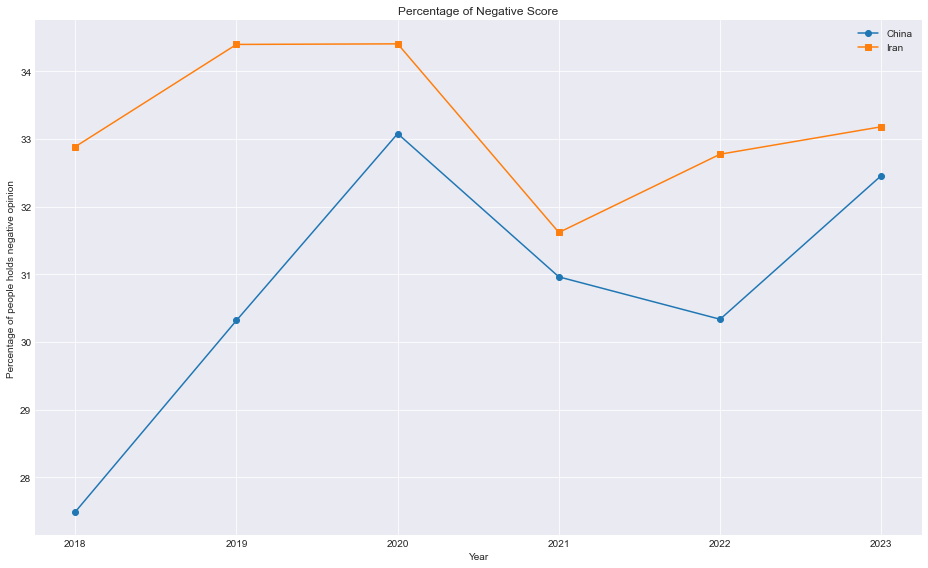

In [35]:
import matplotlib.pyplot as plt
# Setting the style
plt.style.use('seaborn-darkgrid')

# Extract the year from 'year_month' and create a new column 'year'
# pivot_table['year'] = pivot_table['year_month'].str[:4]

# Group by 'year' and calculate the mean sentiment scores again
annual_means = pivot_table.groupby('year').mean().reset_index()

# Plotting
plt.figure(figsize=(13,8))  # Set the figure size for better readability
plt.plot(annual_means['year'], annual_means['china'], marker='o', label='China')
plt.plot(annual_means['year'], annual_means['iran'], marker='s', label='Iran')

# Adding titles and labels
plt.title('Percentage of Negative Score')
plt.xlabel('Year')
plt.ylabel('Percentage of people holds negative opinion')
plt.legend()  # Show the legend to indicate which line corresponds to which country

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.show()


In [178]:
grouped = countries.groupby(['year_month', 'country']).sentiment.mean().reset_index()
pivot_table = grouped.pivot(index='year_month', columns='country', values='sentiment').reset_index()
pivot_table.columns.name = None  # Removes the name 'country' from the columns
pivot_table = pivot_table.rename(columns={'China': 'china', 'Iran': 'iran'})

print(pivot_table)

  year_month     china      iran
0       2018  0.046001 -0.023713
1       2019  0.033290 -0.042258
2       2020 -0.043876 -0.038373
3       2021  0.007878 -0.026175
4       2022  0.027034 -0.040627
5       2023 -0.016123 -0.049062


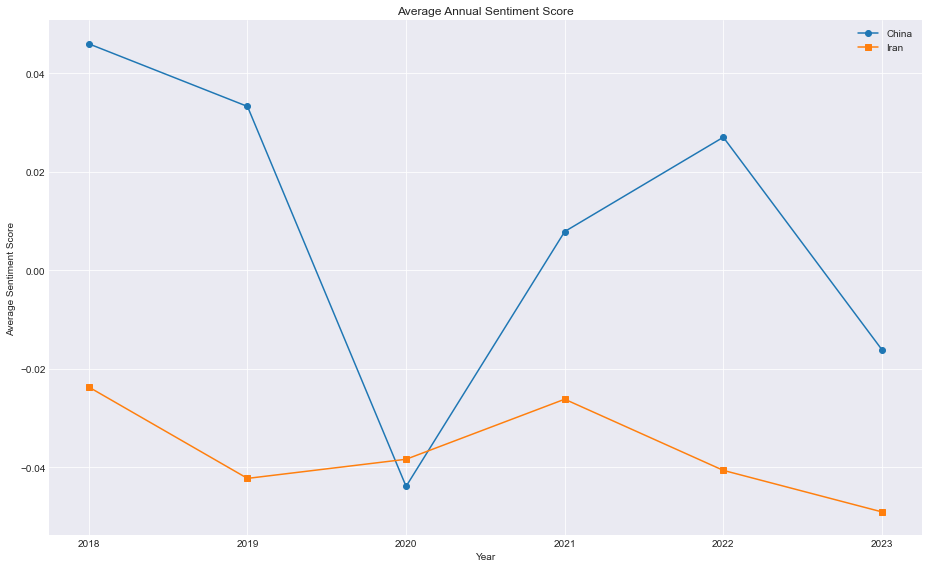

In [179]:
import matplotlib.pyplot as plt
# Setting the style
plt.style.use('seaborn-darkgrid')

# Extract the year from 'year_month' and create a new column 'year'
pivot_table['year'] = pivot_table['year_month'].str[:4]

# Group by 'year' and calculate the mean sentiment scores again
annual_means = pivot_table.groupby('year').mean().reset_index()

# Plotting
plt.figure(figsize=(13,8))  # Set the figure size for better readability
plt.plot(annual_means['year'], annual_means['china'], marker='o', label='China')
plt.plot(annual_means['year'], annual_means['iran'], marker='s', label='Iran')

# Adding titles and labels
plt.title('Average Annual Sentiment Score')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend()  # Show the legend to indicate which line corresponds to which country

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.show()


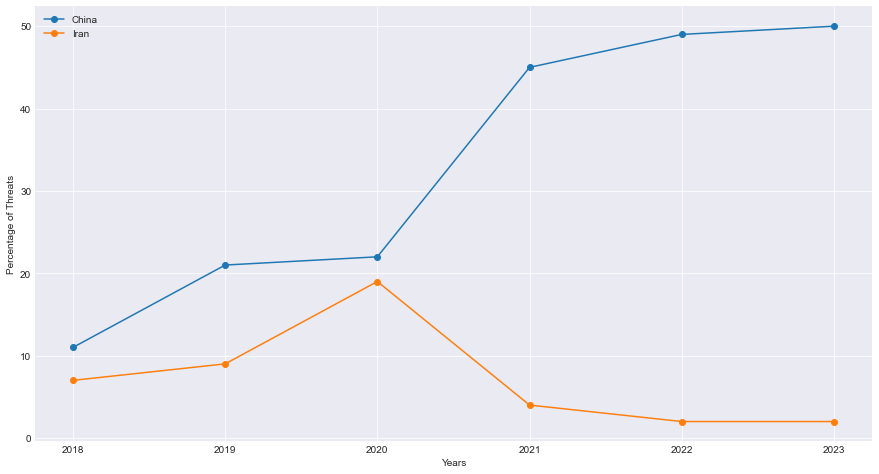

In [113]:
gallup3 = pd.read_csv("/Users/chris/Desktop/Thesis/Data/gallup_cleaned.csv")
# Setting the style
plt.style.use('seaborn-darkgrid')

# Create a color palette
palette = plt.get_cmap('tab10')  # Using 'tab10' for a broad range of distinct colors

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,2],marker='o', label='China')
# ax.plot(gallup3.iloc[:,0], gallup3.iloc[4:,3],marker='o', label='Russia')
# ax.plot(gallup3.iloc[:,0], gallup3.iloc[4:,4],marker='o', label='North Korea')
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,5],marker='o', label='Iran')

ax.set_xlabel('Years')
ax.set_ylabel('Percentage of Threats')
ax.legend()

### Sentiment Score Distribution 

Text(0.5, 1.0, 'iran Sentiment distribution')

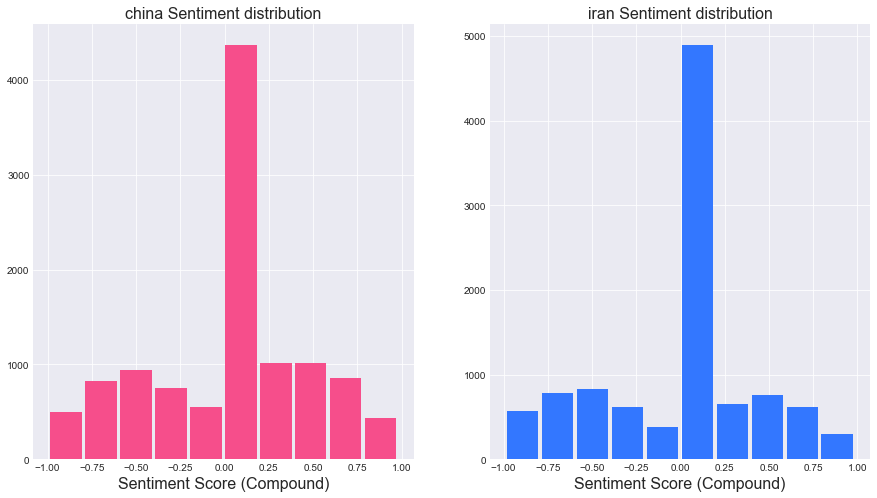

In [68]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
axs[0].hist(china['sentiment'],histtype='bar', facecolor='#F64E8B', rwidth=0.9)
axs[0].set_xlabel('Sentiment Score (Compound)', fontsize=16)
axs[0].set_title('china Sentiment distribution', fontsize=16)

axs[1].hist(iran['sentiment'],histtype='bar', facecolor='#3377FF', rwidth=0.9)
axs[1].set_xlabel('Sentiment Score (Compound)', fontsize=16)
axs[1].set_title('iran Sentiment distribution', fontsize=16)

# axs[2].hist(iran['sentiment'],histtype='bar', facecolor='#FFB233', rwidth=0.9)
# axs[2].set_xlabel('Sentiment Score (Compound)', fontsize=16)
# axs[2].set_title('North Korean Sentiment distribution', fontsize=16)

# axs[3].hist(iran['sentiment'],histtype='bar', facecolor='#9333FF', rwidth=0.9)
# axs[3].set_xlabel('Sentiment Score (Compound)', fontsize=16)
# axs[3].set_title('Russia Sentiment distribution', fontsize=16)

## Topic Modeling

In [55]:
china_2021 = china[china['year_month']=='2021']
china_2022 = china[china['year_month']=='2022']

Text(0.5, 1.0, 'China Sentiment distribution 2022')

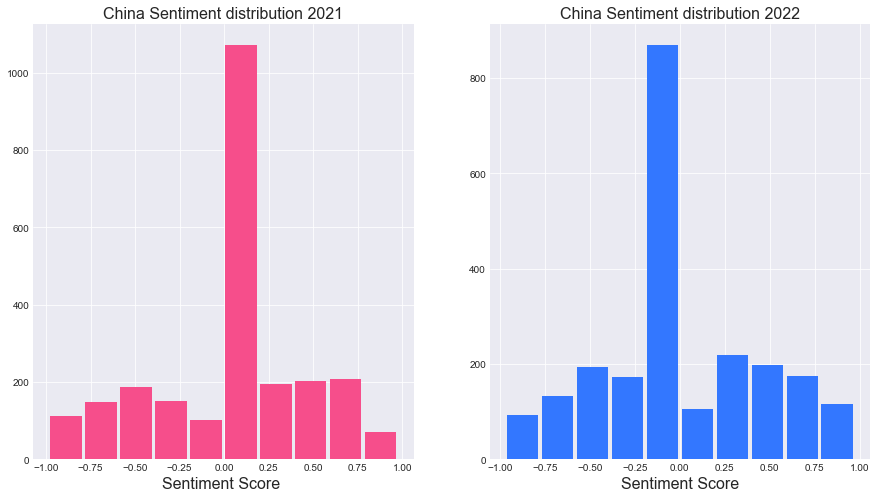

In [69]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
axs[0].hist(china_2021['sentiment'],histtype='bar', facecolor='#F64E8B', rwidth=0.9)
axs[0].set_xlabel('Sentiment Score ', fontsize=16)
axs[0].set_title('China Sentiment distribution 2021', fontsize=16)

axs[1].hist(china_2022['sentiment'],histtype='bar', facecolor='#3377FF', rwidth=0.9)
axs[1].set_xlabel('Sentiment Score', fontsize=16)
axs[1].set_title('China Sentiment distribution 2022', fontsize=16)

### China 2021

In [70]:
china_2021_1 = china_2021[china_2021['sentiment']<0.25]
china_2021_2 = china_2021_1[china_2021_1['sentiment']>0]
china_2021_2.iloc[0:50].sort_values(by='sentiment', ascending=False)

,orig_text,url,user_id_str,month,translated,country,sentiment,year_month
1884,esto esra muy bien el gobierno marxista comuni...,https://twitter.com/JavierD35500107/status/146...,1.253800e+18,11,"This is very good, the communist Marxist gover...",china,0.2484,2021
1966,chvnoticias puta prefiero volver los 80 que vo...,https://twitter.com/FernandoCS_4/status/145495...,1.092928e+18,10,chvnews bitch I prefer to go back to the 80's ...,china,0.2484,2021
1620,leo829418 preciso ser muito idiota pra acredit...,https://twitter.com/ninguem_anyone/status/1366...,2.700300e+09,02,leo829418 you have to be a very idiot to belie...,china,0.2271,2021
1639,nada q venga de china es bueno la intervencin ...,https://twitter.com/Matiz1Paola/status/1356029...,7.153515e+17,01,Nothing that comes from China is good. Genetic...,china,0.2263,2021
1484,uma curiosidade aqui na china drago smbolo bom...,https://twitter.com/nicaksks/status/1388281007...,7.521990e+17,04,"It's a curiosity here in China, the dragon is ...",china,0.2263,2021
1544,mfelten25 maxabrahms think china probably okay...,https://twitter.com/parasolstand/status/143285...,1.327598e+18,08,mfelten25 maxabrahms think china probably okay...,china,0.2263,2021
1887,rich peril china,https://twitter.com/satishkolls/status/1465832...,1.774043e+07,11,rich peril china,china,0.2263,2021
5626,ronchowanetz corleone roller china look port s...,https://twitter.com/jimmy140378/status/1432855...,1.243134e+18,08,ronchowanetz corleone roller china look port s...,china,0.2263,2021
1965,china quiere liderar en computacin cuntica la ...,https://twitter.com/oro_negro26/status/1454959...,1.195703e+09,10,"China wants to lead in quantum computing, the ...",china,0.2263,2021
1517,chinita ix hey china lo mismo hago yo verga ni...,https://twitter.com/boss_1063/status/143285528...,8.670956e+17,08,"chinita ix hey china I do the same thing, don'...",china,0.2235,2021


In [71]:
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(china_2021_2['translated'])

# Create an LSA model with 10 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('translated: ',china_2021_2.iloc[idx]['translated'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
china
fine
chinese
dasc839
silly
peril
rich
government
want
people


translated:  fine china
translated:  fine china
translated:  dasc839 china silly 7
translated:  dasc839 china silly 7
translated:  rich peril china


Topic 1: 
chinese
government
want
food
xinjiang
know
workers
covid
nigeria
actually


translated:  chinese food i want
translated:  us commerce secretary gina raimondo dont know boeing heretheres tens billions dollars planes chinese airlines want buy chinese government standing way
translated:  chinese government apologists actually believed marxist philosophy claim support would fighting release chinese marxist student organizers amp factory workers disappeared ccp daring organize workers rights
translated:  chinese government ready help nigeria reduce level poverty nation mr cui jianchm chinese ambassador nigeria 
translated:  chinese lawyer chenqiushi forcibly disappeared chinese government reporting early stages covid pandemic 2020 suddenly reappeared appar

### China 2022

In [72]:
china_2022_1 = china_2021[china_2021['sentiment']<0]
china_2022_2 = china_2021_1[china_2021_1['sentiment']> -0.25]
china_2022_2.iloc[0:50].sort_values(by='sentiment', ascending=False)

,orig_text,url,user_id_str,month,translated,country,sentiment,year_month
1484,uma curiosidade aqui na china drago smbolo bom...,https://twitter.com/nicaksks/status/1388281007...,7.521990e+17,04,"It's a curiosity here in China, the dragon is ...",china,0.2263,2021
1517,chinita ix hey china lo mismo hago yo verga ni...,https://twitter.com/boss_1063/status/143285528...,8.670956e+17,08,"chinita ix hey china I do the same thing, don'...",china,0.2235,2021
1489,jorgeesteve8 carsalomone francholandia octavio...,https://twitter.com/Lomas2214/status/138828099...,8.590308e+17,04,jorgeesteve8 carsalomone francoland octaviocri...,china,0.1531,2021
1463,tn eua alegam que china tem falhado com compro...,https://twitter.com/Fonte_TradeNews/status/138...,3.632484e+08,04,tn usa allege china has failed to meet intelle...,china,0.1280,2021
1515,intelbras j enviei produto via correio pr devo...,https://twitter.com/Passari21183993/status/143...,1.409927e+18,08,intelbras I have already sent the product via ...,china,0.0258,2021
1445,pauloeneas meu amigo ns compramos carne vermel...,https://twitter.com/PauloRo35512391/status/138...,1.294967e+18,04,pauloeneas my friend we buy red meat and the p...,china,0.0258,2021
1430,resignrepublican centr comment eu digital serv...,https://twitter.com/DomainInvestor3/status/138...,1.385300e+18,04,resignrepublican centr comment eu digital serv...,china,0.0000,2021
1502,merumaga china 93,https://twitter.com/UdonMarugame/status/143285...,8.701962e+17,08,merumaga china 93,china,0.0000,2021
1476,nanodelchuy ahh era jeringoso lo que hablabala...,https://twitter.com/GustavoGonzaUy/status/1388...,4.099477e+08,04,nanodelchuy ahh it was syringous what he was t...,china,0.0000,2021
1477,rosangellafp tiene miedo el amauta se corren l...,https://twitter.com/miguelrojos50/status/13882...,4.741723e+08,04,rosangellafp is afraid the amauta cums he is a...,china,0.0000,2021


In [73]:
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(china_2022_2['translated'])

# Create an LSA model with 10 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('translated: ',china_2022_2.iloc[idx]['translated'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
china
xuexi
la
que
en
el
keikofujimori
communist
es
epochtimes


translated:  China
translated:  china
translated:  china
translated:  china
translated:  china


Topic 1: 
communist
religious
believers
books
burned
seized
jail
given
epochtimes
terms


translated:  religious books seized burned communist china believers given jail terms  via epochtimes
translated:  religious books seized burned communist china believers given jail terms  via epochtimes
translated:  religious books seized burned communist china believers given jail terms  via epochtimes
translated:  religious books seized burned communist china believers given jail terms  via epochtimes
translated:  religious books seized burned communist china believers given jail terms  via epochtimes


Topic 2: 
xuexi
china
dujinquan1
mizuki
keikofujimori
come
girl
fine
russia
takes


translated:  china xuexi h
translated:  china xuexi h
translated:  china xuexi h
translated:  china xuexi h
translated:  china xuexi h


Topic